# Ball simulation

This part is dedicated to create the simulation of the ball dynamics, depending of the plateau angle.

## External imports

In [1]:
import numpy as np
import pandas as pd
import csv
import os
import matplotlib
import matplotlib.pyplot as plt

from torch.autograd import Variable
from sklearn.linear_model import LinearRegression
from matplotlib import cm
from matplotlib.ticker import LinearLocator

%matplotlib notebook

## Internal imports

In [2]:
from src import *
from src.constants import DT
print(DT)

0.002


# Simulation

p_t+1 = p_t + s_t * dt

p = [x, y]

s = [d_x, d_y]

## Data preparation

In this part, the recorded data are loaded and prepared. The goal is to train the neural network on those datas.

In [3]:
data_file_names = os.listdir('src/data/train')
test_data_file_names = os.listdir('src/data/test')

In [4]:
datas = [pd.read_csv('src/data/train/{}'.format(file_name)) for file_name in data_file_names if 'ball' in file_name]
test_datas = [pd.read_csv('src/data/test/{}'.format(file_name)) for file_name in test_data_file_names if 'ball' in file_name]

Data visualisation

<IPython.core.display.Javascript object>


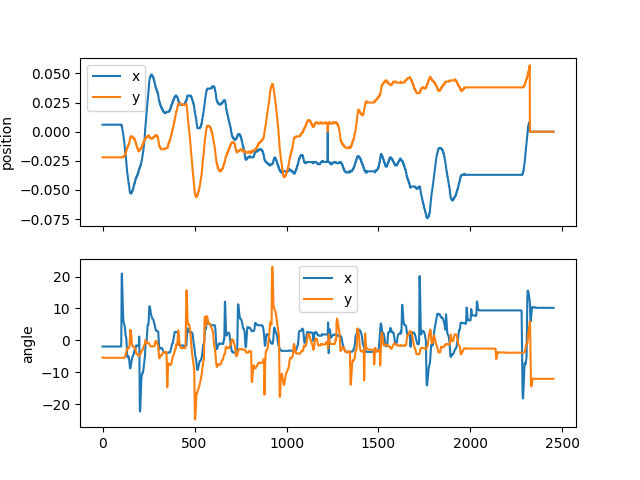

In [5]:
for data in datas[:1]:
    fig, axs = plt.subplots(2, 1, sharex=True)

    axs[0].plot(data['x'], label='x')
    axs[0].plot(data['y'], label='y')
    axs[0].set_ylabel('position')
    axs[0].legend()

    axs[1].plot(data['angle_x'], label='x')
    axs[1].plot(data['angle_y'], label='y')
    axs[1].set_ylabel('angle')
    axs[1].legend()

    plt.show()

It is possible to see that at some moments, the ball was undetected. Either for a one timestep, either for the whole end.

Regressions are very sensitive to outliers, thus it is very important to remove those errors

In [6]:
for data in datas:
    data.drop(data.loc[data['x']==0].index, inplace=True)
for data in test_datas:
    data.drop(data.loc[data['x']==0].index, inplace=True)
    
datas[-1] = datas[-1].iloc[:380, :]

<IPython.core.display.Javascript object>


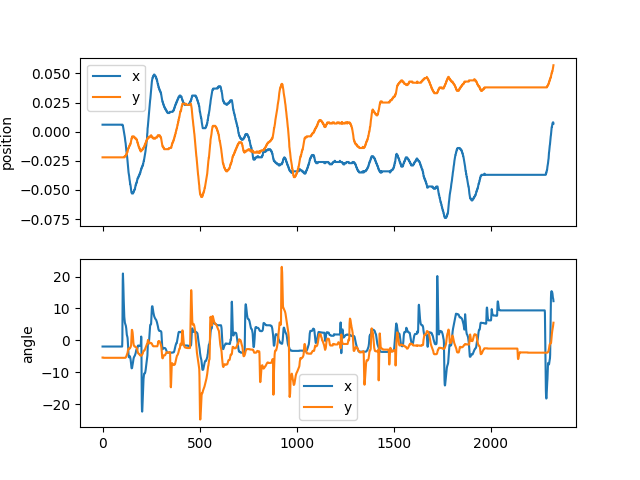

In [7]:
for data in datas[:1]:
    fig, axs = plt.subplots(2, 1, sharex=True)

    axs[0].plot(data['x'], label='x')
    axs[0].plot(data['y'], label='y')
    axs[0].set_ylabel('position')
    axs[0].legend()

    axs[1].plot(data['angle_x'], label='x')
    axs[1].plot(data['angle_y'], label='y')
    axs[1].set_ylabel('angle')
    axs[1].legend()

    plt.show()

In [8]:
'''for data in test_datas:
    fig, axs = plt.subplots(2, 1, sharex=True)

    axs[0].plot(data['x'], label='x')
    axs[0].plot(data['y'], label='y')
    axs[0].set_ylabel('position')
    axs[0].legend()

    axs[1].plot(data['angle_x'], label='x')
    axs[1].plot(data['angle_y'], label='y')
    axs[1].set_ylabel('angle')
    axs[1].legend()

    plt.show()'''

"for data in test_datas:\n    fig, axs = plt.subplots(2, 1, sharex=True)\n\n    axs[0].plot(data['x'], label='x')\n    axs[0].plot(data['y'], label='y')\n    axs[0].set_ylabel('position')\n    axs[0].legend()\n\n    axs[1].plot(data['angle_x'], label='x')\n    axs[1].plot(data['angle_y'], label='y')\n    axs[1].set_ylabel('angle')\n    axs[1].legend()\n\n    plt.show()"

Since all datasets are cleaned. It is now possible to compute the speed and concaten them.

In [9]:
lag: int = 8

for data in datas:
    data['sin_angle_x'] = np.sin(data['angle_x'] * np.pi / 180.)
    data['sin_angle_y'] = np.sin(data['angle_y'] * np.pi / 180.)
    data['d_x'] = ((data['x'] - data['x'].shift(lag + 1)) / (DT * (lag + 1))).rolling(window=lag+1).mean()
    data['d_y'] = ((data['y'] - data['y'].shift(lag + 1)) / (DT * (lag + 1))).rolling(window=lag+1).mean()
    data['tl'] = np.where((data['x']<0.) & (data['y']>0.), 1., 0.)
    data['br'] = np.where((data['x']>0.) & (data['y']<0.), 1., 0.)
    data['bl'] = np.where((data['x']<0.) & (data['y']<0.), 1., 0.)
    data['tr'] = np.where((data['x']>0.) & (data['y']>0.), 1., 0.)
    data['target_x'] = data['d_x'].shift(-1) - data['d_x']
    data['target_y'] = data['d_y'].shift(-1) - data['d_y']
    data.dropna(inplace=True)
for data in test_datas:
    data['sin_angle_x'] = np.sin(data['angle_x'] * np.pi / 180.)
    data['sin_angle_y'] = np.sin(data['angle_y'] * np.pi / 180.)
    data['d_x'] = ((data['x'] - data['x'].shift(lag + 1)) / (DT * (lag + 1))).rolling(window=lag+1).mean()
    data['d_y'] = ((data['y'] - data['y'].shift(lag + 1)) / (DT * (lag + 1))).rolling(window=lag+1).mean()
    data['tl'] = np.where((data['x']<0.) & (data['y']>0.), 1., 0.)
    data['br'] = np.where((data['x']>0.) & (data['y']<0.), 1., 0.)
    data['bl'] = np.where((data['x']<0.) & (data['y']<0.), 1., 0.)
    data['tr'] = np.where((data['x']>0.) & (data['y']>0.), 1., 0.)
    data['target_x'] = data['d_x'].shift(-1) - data['d_x']
    data['target_y'] = data['d_y'].shift(-1) - data['d_y']
    data.dropna(inplace=True)
    
data = datas[0]
for df in datas[0:]:
    data = pd.concat([data, df])
data.reset_index(inplace=True, drop=True)
print(data.head())

       x      y  angle_x  angle_y  input_x  input_y  sin_angle_x  sin_angle_y  \
0  0.006 -0.022   -1.929   -5.464   -0.211   -0.190    -0.033661     -0.09522   
1  0.006 -0.022   -1.929   -5.464   -0.206   -0.185    -0.033661     -0.09522   
2  0.006 -0.022   -1.929   -5.464   -0.205   -0.185    -0.033661     -0.09522   
3  0.006 -0.022   -1.929   -5.464   -0.203   -0.185    -0.033661     -0.09522   
4  0.006 -0.022   -1.929   -5.464   -0.205   -0.195    -0.033661     -0.09522   

   d_x  d_y   tl   br   bl   tr  target_x  target_y  
0  0.0  0.0  0.0  1.0  0.0  0.0       0.0       0.0  
1  0.0  0.0  0.0  1.0  0.0  0.0       0.0       0.0  
2  0.0  0.0  0.0  1.0  0.0  0.0       0.0       0.0  
3  0.0  0.0  0.0  1.0  0.0  0.0       0.0       0.0  
4  0.0  0.0  0.0  1.0  0.0  0.0       0.0       0.0  


In [10]:
'''for data in test_datas:
    fig, axs = plt.subplots(2, 1, sharex=True)

    axs[0].plot(data['d_x'], label='d_x')
    axs[0].plot(data['d_y'], label='d_y')
    axs[0].set_ylabel('position')
    axs[0].legend()

    axs[1].plot(data['angle_x'], label='angle_x')
    axs[1].plot(data['angle_y'], label='angle_y')
    axs[1].set_ylabel('angle')
    axs[1].legend()

    plt.show()'''

"for data in test_datas:\n    fig, axs = plt.subplots(2, 1, sharex=True)\n\n    axs[0].plot(data['d_x'], label='d_x')\n    axs[0].plot(data['d_y'], label='d_y')\n    axs[0].set_ylabel('position')\n    axs[0].legend()\n\n    axs[1].plot(data['angle_x'], label='angle_x')\n    axs[1].plot(data['angle_y'], label='angle_y')\n    axs[1].set_ylabel('angle')\n    axs[1].legend()\n\n    plt.show()"

## Scaling

In [11]:
max(- data['x'].min(), data['x'].max())

0.08199999999999999

In [12]:
max(- data['y'].min(), data['y'].max())

0.055999999999999994

In [13]:
max(- data['d_x'].min(), data['d_x'].max(), - data['d_y'].min(), data['d_y'].max())

2.0185185185185173

In [14]:
data['d_x'].std()

0.3291415966108057

In [15]:
data['d_x'].abs().mean()

0.19772426570164944

In [16]:
data['sin_angle_x'].abs().mean()

0.07205134039614904

In [17]:
data['sin_angle_x'].std()

0.09472101892094129

In [18]:
data['target_x'].abs().mean()

0.014288347364677356

## Inputs

- x * 15
- y * 20
- d_x
- d_y
- sin_angle_x * 10
- sin_angle_y * 10

## Output
- d_x
- d_y

In [19]:
x_np = data[['tr', 'tl','br', 'bl', 'd_x', 'd_y', 'sin_angle_x', 'sin_angle_y']].to_numpy()

x_np[:, 4] = x_np[:, 4]
x_np[:, 5] = x_np[:, 5]
x_np[:, 6] = x_np[:, 6] * 10.
x_np[:, 7] = x_np[:, 7] * 10.

y_np = data[['target_x', 'target_y']].to_numpy()

x = Variable(
    torch.from_numpy(
        x_np
    ).type(torch.FloatTensor)
)

y = Variable(
    torch.from_numpy(y_np).type(torch.FloatTensor)
)

<IPython.core.display.Javascript object>


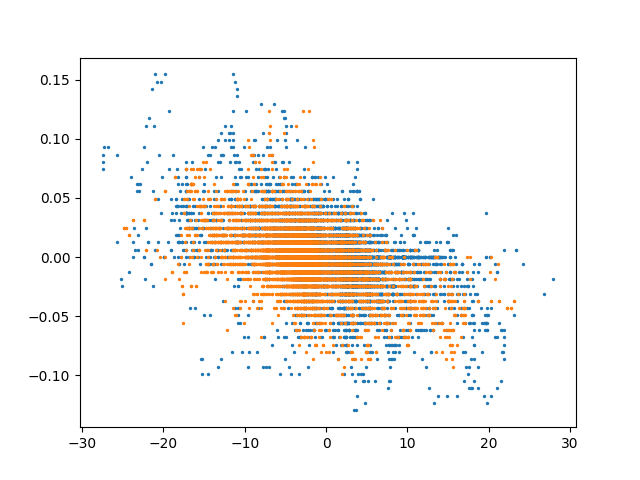

In [20]:
plt.figure()
plt.scatter(data['angle_x'], y_np[:, 0], s=2)

plt.scatter(data['angle_y'], y_np[:, 1], s=2)

plt.show()

## Physic model

a = 2 * m_b * g * r_arm * r_b² / L / (m_b * r_b² + J_b) * sin(angle) = A * sin(angle)

d_x_t+1 = d_x_t + a * d_t = d_x_t + A' * sin(angle)

In [21]:
phy_x = x_np[:, 6:]
reg = LinearRegression().fit(phy_x, y_np)
print('R2 score', reg.score(phy_x, y_np))
print('coef',reg.coef_)
print('coef',reg.intercept_)

R2 score 0.21698485033535
coef [[-0.01091483 -0.00085662]
 [ 0.00042964 -0.01176969]]
coef [ 0.00084107 -0.00592119]


/home/benoit/.local/lib/python3.6/site-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


In [22]:
def recurcive_phy_sim(x_0, y_0, d_x_0, d_y_0, inputs):
    pos: np.ndarray = np.zeros((inputs.shape[0], 2))
    pos[0, 0] = x_0
    pos[0, 1] = y_0

    d_x = d_x_0
    d_y = d_y_0

    for i in range(1, inputs.shape[0]):
        pred = np.dot(reg.coef_, inputs[i - 1, :] * 10) + reg.intercept_
        d_x += pred[0]
        d_y += pred[1]
        pos[i, 0] = max(min(pos[i - 1, 0] + d_x * DT, MAX_X), -MAX_X)
        pos[i, 1] = max(min(pos[i - 1, 1] + d_y * DT, MAX_Y), -MAX_Y)
    return pos

### Physical model with friction

d_x_t+1 = d_x_t + a * d_t = d_x_t + A' * sin(angle) + c_f * d_x

In [23]:
phy_x_f = x_np[:, 4:]
reg_f = LinearRegression().fit(phy_x_f, y_np)
print('R2 score', reg_f.score(phy_x_f, y_np))
print('coef',reg_f.coef_)
print('coef',reg_f.intercept_)

R2 score 0.22618446032457915
coef [[ 6.03643927e-03 -1.88423403e-03 -1.13915507e-02 -4.55467662e-04]
 [ 1.53065330e-03  7.54596630e-03  8.52902845e-05 -1.22719440e-02]]
coef [ 0.00107786 -0.0061662 ]


/home/benoit/.local/lib/python3.6/site-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


In [24]:
def recurcive_phy_f_sim(x_0, y_0, d_x_0, d_y_0, inputs):
    pos: np.ndarray = np.zeros((inputs.shape[0], 2))
    pos[0, 0] = x_0
    pos[0, 1] = y_0
    
    inputs[:, 2] = inputs[:, 2] * 10.
    inputs[:, 3] = inputs[:, 3] * 10.

    d_x = d_x_0
    d_y = d_y_0

    for i in range(1, inputs.shape[0]):
        pred = np.dot(reg_f.coef_, inputs[i - 1, :]) + reg_f.intercept_
        d_x += pred[0]
        d_y += pred[1]
        pos[i, 0] = max(min(pos[i - 1, 0] + d_x * DT, MAX_X), -MAX_X)
        pos[i, 1] = max(min(pos[i - 1, 1] + d_y * DT, MAX_Y), -MAX_Y)
    return pos

### Physical model with position correction

d_x_t+1 = d_x_t + a * d_t = d_x_t + A' * c_f * d_x + sin(angle) + c_tr * tr + c_tl * tl * c_br * br + c_bl * bl

In [25]:
reg_corr = LinearRegression().fit(x_np, y_np)
print('R2 score', reg_corr.score(x_np, y_np))
print('coef',reg_corr.coef_)
print('coef',reg_corr.intercept_)

R2 score 0.2370626385975705
coef [[ 4.90725971e-03  1.01736357e-02  2.96181461e-03  5.86330294e-03
   6.94952547e-03 -2.15539578e-03 -1.12089730e-02 -1.57683165e-03]
 [ 1.07960264e-03  4.31080021e-03  4.95672144e-03  2.40203759e-03
   1.49558972e-03  7.81167947e-03  8.77934072e-05 -1.24971744e-02]]
coef [-0.00581444 -0.00942309]


/home/benoit/.local/lib/python3.6/site-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


In [26]:
def recurcive_phy_corr_sim(x_0, y_0, d_x_0, d_y_0, inputs):
    pos: np.ndarray = np.zeros((inputs.shape[0], 2))
    pos[0, 0] = x_0
    pos[0, 1] = y_0
    
    inputs[:, 4] = inputs[:, 6] * 10.
    inputs[:, 5] = inputs[:, 7] * 10.

    d_x = d_x_0
    d_y = d_y_0

    for i in range(1, inputs.shape[0]):
        pred = np.dot(reg_corr.coef_, inputs[i - 1, :]) + reg_corr.intercept_
        d_x += pred[0]
        d_y += pred[1]
        pos[i, 0] = max(min(pos[i - 1, 0] + d_x * DT, MAX_X), -MAX_X)
        pos[i, 1] = max(min(pos[i - 1, 1] + d_y * DT, MAX_Y), -MAX_Y)
    return pos

# Neural network training
Since the ball behavior isn't linear, multiples NN are created and trained to model the system.

The inputs and targets are converted into pytorch format

In [27]:
nets = [BallNet1Hidden(6, 16, 2), BallNet1Hidden(6, 32, 2), BallNet1Hidden(6, 64, 2), 
        BallNet1Hidden(6, 128, 2), BallNet2Hidden(6, 16, 16, 2), BallNet2Hidden(6, 32, 16, 2),
        BallNet2Hidden(6, 64, 32, 2), BallNet2Hidden(6, 128, 64, 2), BallNet2Hidden(6, 128, 128, 2)]
nets = [BallNet1Hidden(8, 8, 2)]

In [28]:
nets = [train_ball_model(net, x, y, n_epoch=300) for net in nets]

tensor(0.0005, grad_fn=<MseLossBackward>)
tensor(0.0005, grad_fn=<MseLossBackward>)
tensor(0.0005, grad_fn=<MseLossBackward>)
tensor(0.0005, grad_fn=<MseLossBackward>) -69.06738710615528


## Test

In [29]:
test_index = 0
test = test_datas[test_index][['tr', 'tl','br', 'bl', 'd_x', 'd_y', 'sin_angle_x', 'sin_angle_y']].to_numpy()

x_0 = test_datas[test_index]['x'].iloc[0]
y_0 = test_datas[test_index]['y'].iloc[0]
d_x_0 = test_datas[test_index]['d_x'].iloc[0]
d_y_0 = test_datas[test_index]['d_y'].iloc[0]

phy_pos = recurcive_phy_sim(x_0, y_0, d_x_0, d_y_0, test[:, 6:])
print(test[:, 6:])

phy_pos_f = recurcive_phy_f_sim(x_0, y_0, d_x_0, d_y_0, test[:, 4:])

phy_pos_corr = recurcive_phy_corr_sim(x_0, y_0, d_x_0, d_y_0, test)

[[ 0.03925982 -0.09662751]
 [ 0.03925982 -0.09662751]
 [ 0.03925982 -0.09662751]
 ...
 [-0.01963369  0.1161507 ]
 [-0.01963369  0.10638555]
 [-0.01963369  0.09522031]]


In [30]:
pos_nn = nets[0].recurcive_predict(x_0, y_0, d_x_0, d_y_0, test[:, :])

<IPython.core.display.Javascript object>


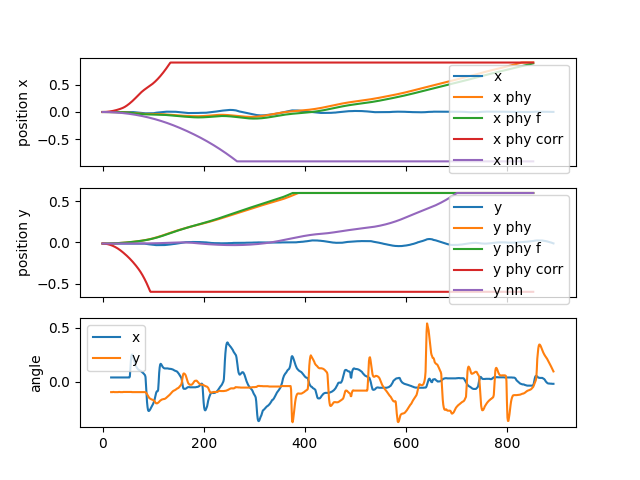

In [31]:
fig, axs = plt.subplots(3, 1, sharex=True)

axs[0].plot(test_datas[test_index]['x'], label='x')
axs[0].plot(phy_pos[:, 0], label='x phy')
axs[0].plot(phy_pos_f[:, 0], label='x phy f')
axs[0].plot(phy_pos_corr[:, 0], label='x phy corr')
axs[0].plot(pos_nn[:, 0], label='x nn')
axs[0].set_ylabel('position x')
axs[0].legend()

axs[1].plot(test_datas[test_index]['y'], label='y')
axs[1].plot(phy_pos[:, 1], label='y phy')
axs[1].plot(phy_pos_f[:, 1], label='y phy f')
axs[1].plot(phy_pos_corr[:, 1], label='y phy corr')
axs[1].plot(pos_nn[:, 1], label='y nn')
axs[1].set_ylabel('position y')
axs[1].legend()

axs[2].plot(test_datas[test_index]['sin_angle_x'], label='x')
axs[2].plot(test_datas[test_index]['sin_angle_y'], label='y')
axs[2].set_ylabel('angle')
axs[2].legend()

plt.show()

In [32]:
ball = {
    'phy_i_coef': reg_f.coef_.tolist(),
    'phy_i_bias': reg_f.intercept_.tolist(),
    's_scaling': 1.,
    'sin_scaling': 10.
}

with open('src/data/ball.json', 'w') as json_file:
    json.dump(ball, json_file)

In [33]:
a = BallSimulation()

{'phy_i_coef': [[0.006036439268119378, -0.0018842340262572553, -0.011391550735298041, -0.000455467661831954], [0.0015306533035702257, 0.007545966304583746, 8.529028447244735e-05, -0.012271944038403522]], 'phy_i_bias': [0.0010778589754901937, -0.006166195243763948], 's_scaling': 1.0, 'sin_scaling': 10.0}
